## HOUSE PRICES SOLUTION - PART II MODELING


## Modeling
>* **Import libraries and files prepared for modeling + spliting the data set in 2 parts: Train and test**
* **Define functions for model evaluation: MAE and RMSLE (as per the assignment instructions) and additional parameters to evaluate models: R2** (modeling will be based on SalePrice and not the log transformed)
* **Define the Baseline model: MAE median**
* **Model 1 "Simple" based on 2 features**: 2 models
* **Evaluate feature importance: correlation matrix, p-values and feature importance analysis with Random Forest Classifier**
* **Model 2 "Intermediate" based on 16 (+2) features** + benchmark model as describe in the "Alternative Boston House Price" article + Ridge Regression with Grid Search optimization
* **Model 3 "Complex" based on all variables** + Ridge Regression with Grid Search optimization
* **Adding Ridge Regression** and Grid Search Optimization to Model 2b and Model 3
* **Evaluation and decision**

### Import libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
%matplotlib inline
from pandas.tseries.offsets import *
import seaborn as sns
import re
from sklearn.preprocessing import Normalizer
import sqlite3
import os
from sklearn.linear_model import SGDRegressor
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import HuberRegressor
from scipy.linalg import lstsq # multiple linear regression
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error as mse
from sklearn.linear_model import Ridge
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import LabelEncoder
from sklearn import preprocessing
from scipy.stats import kurtosis
from scipy.stats import skew
from scipy import stats

from sklearn import datasets, linear_model
import statsmodels.api as sm
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import QuantileTransformer
from sklearn.cluster import KMeans

import warnings
warnings.simplefilter("ignore")

In [2]:
with warnings.catch_warnings():
    pd.set_option('mode.chained_assignment', None)

warnings.filterwarnings(action='once')
pd.set_option('mode.chained_assignment', None)

In [3]:
# display all columns
pd.set_option('display.max_columns', None)

In [4]:
# Load data
hp_model = pd.read_csv('C:/Users/fbaff/EPFL ML Python/3- Machine Learning 1/ML1 Project submission/HousePrice_model_new.csv')

In [5]:
# remove the Unnamed column
hp_model.drop('Unnamed: 0', axis=1, inplace=True)
hp_model.shape

(2414, 212)

In [6]:
hp_model.head()

,Bsmt Full Bath,Bsmt Half Bath,Bsmt Unf SF,BsmtFin SF 1,BsmtFin SF 2,Fireplaces,Full Bath,Garage Area,Garage Cars,Half Bath,LogSalePrice,Lot Area,Lot Frontage,MS SubClass,Mo Sold,Order,Overall Cond,Overall Qual,PID,SalePrice,TotRms AbvGrd,Year Built,Year Remod/Add,Yr Sold,Tot_liv_SF,Tot_ext_SF,Gr_tot_SF,SF_ind,Remod_ind,Log_LotArea,Lot Shape,Bsmt Qual,Bsmt Cond,Bsmt Exposure,BsmtFin Type 1,BsmtFin Type 2,Heating QC,Electrical,Kitchen Qual,Functional,Fireplace Qu,Garage Finish,Garage Qual,Garage Cond,Paved Drive,Exter Qual,Exter Cond,Utilities,Land Slope,Bldg Type_1Fam,Bldg Type_2fmCon,Bldg Type_Duplex,Bldg Type_Twnhs,Bldg Type_TwnhsE,Central Air_N,Central Air_Y,Condition 1_Artery,Condition 1_Feedr,Condition 1_Norm,Condition 1_PosA,Condition 1_PosN,Condition 1_RRAe,Condition 1_RRAn,Condition 1_RRNe,Condition 1_RRNn,Condition 2_Artery,Condition 2_Feedr,Condition 2_Norm,Condition 2_PosA,Condition 2_PosN,Condition 2_RRAe,Condition 2_RRAn,Condition 2_RRNn,Exterior 1st_AsbShng,Exterior 1st_AsphShn,Exterior 1st_BrkComm,Exterior 1st_BrkFace,Exterior 1st_CBlock,Exterior 1st_CemntBd,Exterior 1st_HdBoard,Exterior 1st_ImStucc,Exterior 1st_MetalSd,Exterior 1st_Plywood,Exterior 1st_PreCast,Exterior 1st_Stone,Exterior 1st_Stucco,Exterior 1st_VinylSd,Exterior 1st_Wd Sdng,Exterior 1st_WdShing,Exterior 2nd_AsbShng,Exterior 2nd_AsphShn,Exterior 2nd_Brk Cmn,Exterior 2nd_BrkFace,Exterior 2nd_CBlock,Exterior 2nd_CmentBd,Exterior 2nd_HdBoard,Exterior 2nd_ImStucc,Exterior 2nd_MetalSd,Exterior 2nd_Plywood,Exterior 2nd_PreCast,Exterior 2nd_Stone,Exterior 2nd_Stucco,Exterior 2nd_VinylSd,Exterior 2nd_Wd Sdng,Exterior 2nd_Wd Shng,Foundation_BrkTil,Foundation_CBlock,Foundation_PConc,Foundation_Slab,Foundation_Stone,Foundation_Wood,Garage Type_2Types,Garage Type_Attchd,Garage Type_Basment,Garage Type_BuiltIn,Garage Type_CarPort,Garage Type_Detchd,Garage Type_tagada,Heating_Floor,Heating_GasA,Heating_GasW,Heating_Grav,Heating_OthW,Heating_Wall,House Style_1.5Fin,House Style_1.5Unf,House Style_1Story,House Style_2.5Fin,House Style_2.5Unf,House Style_2Story,House Style_SFoyer,House Style_SLvl,Land Contour_Bnk,Land Contour_HLS,Land Contour_Low,Land Contour_Lvl,Lot Config_Corner,Lot Config_CulDSac,Lot Config_FR2,Lot Config_FR3,Lot Config_Inside,MS Zoning_A (agr),MS Zoning_C (all),MS Zoning_FV,MS Zoning_I (all),MS Zoning_RH,MS Zoning_RL,MS Zoning_RM,Mas Vnr Type_BrkCmn,Mas Vnr Type_BrkFace,Mas Vnr Type_CBlock,Mas Vnr Type_None,Mas Vnr Type_Stone,Mas Vnr Type_tagada,Neighborhood_Blmngtn,Neighborhood_Blueste,Neighborhood_BrDale,Neighborhood_BrkSide,Neighborhood_ClearCr,Neighborhood_CollgCr,Neighborhood_Crawfor,Neighborhood_Edwards,Neighborhood_Gilbert,Neighborhood_Greens,Neighborhood_GrnHill,Neighborhood_IDOTRR,Neighborhood_Landmrk,Neighborhood_MeadowV,Neighborhood_Mitchel,Neighborhood_NAmes,Neighborhood_NPkVill,Neighborhood_NWAmes,Neighborhood_NoRidge,Neighborhood_NridgHt,Neighborhood_OldTown,Neighborhood_SWISU,Neighborhood_Sawyer,Neighborhood_SawyerW,Neighborhood_Somerst,Neighborhood_StoneBr,Neighborhood_Timber,Neighborhood_Veenker,Roof Matl_CompShg,Roof Matl_Membran,Roof Matl_Metal,Roof Matl_Tar&Grv,Roof Matl_WdShake,Roof Matl_WdShngl,Roof Style_Flat,Roof Style_Gable,Roof Style_Gambrel,Roof Style_Hip,Roof Style_Mansard,Roof Style_Shed,Sale Condition_Abnorml,Sale Condition_AdjLand,Sale Condition_Alloca,Sale Condition_Family,Sale Condition_Normal,Sale Condition_Partial,Sale Type_COD,Sale Type_CWD,Sale Type_Con,Sale Type_ConLD,Sale Type_ConLI,Sale Type_ConLw,Sale Type_New,Sale Type_Oth,Sale Type_VWD,Sale Type_WD,Street_Grvl,Street_Pave
0,0,0,652,300,0,1,2,554,2,1,5.372912,8795,68,60,4,484,5,7,528275070,236000,8,2000,2000,2009,5464,278,6296,2499,9,3,3,4,3,0,6,1,5,4,4,8,3,3,3,3,2,4,3,3,3,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,

In [7]:
hp_model.dtypes

Bsmt Full Bath    int64
Bsmt Half Bath    int64
Bsmt Unf SF       int64
BsmtFin SF 1      int64
BsmtFin SF 2      int64
                  ...  
Sale Type_Oth     int64
Sale Type_VWD     int64
Sale Type_WD      int64
Street_Grvl       int64
Street_Pave       int64
Length: 212, dtype: object

#### Spliting the data set in train/test

In [8]:
# Split into train/test sets
train_hp, test_hp = train_test_split(
    hp_model, train_size=0.5, test_size=0.5, random_state=0)

print('Train DataFrame:', train_hp.shape)
print('Test DataFrame:', test_hp.shape)

Train DataFrame: (1207, 212)
Test DataFrame: (1207, 212)


#### Define functions and metrics  for model evaluation

In [9]:
# Mean absolute error (MAE) in USD
def MAE(y, y_pred):
    return np.mean(np.abs(y - y_pred))

In [10]:
# Root mean squared error
def RMSE(y, y_pred):
    mse = np.mean(np.square(y - y_pred)) # MSE
    return np.sqrt(mse) # RMSE

#### Define the Baseline model: MAE Median

In [11]:
# Create y_te variables (SalePrice)
y_te = test_hp.SalePrice.values

In [12]:
# MAE baseline (Median)
mae_baseline = MAE(y_te, np.median(y_te))
print('MAE baseline: {:,.0f} dollars'.format(mae_baseline))

MAE baseline: 53,585 dollars


#### Model 1 Simple model
* Selection of 2 explaining features: We will select 2 features whick makes sense à-priori without performing complex feature analysis; i.e surface (Gr_tot_SF or Lot Area/Log_LotArea) and year of construction (YearBuilt)
* The target feature (y) will be LogSalesPrice

In [13]:
# Create a dataframe for X values based on Train/Test with relevant features
train_hp_m1a=train_hp[['Gr_tot_SF','Year Built']]
train_hp_m1b=train_hp[['Log_LotArea', 'Year Built']]
test_hp_m1a=test_hp[['Gr_tot_SF','Year Built']]
test_hp_m1b=test_hp[['Log_LotArea', 'Year Built']]

In [14]:
# Create X variables for simple model (Model 1). We will test 2 simple models
X_tr_m1a=train_hp_m1a.values
X_tr_m1b=train_hp_m1b.values
X_te_m1a=test_hp_m1a.values
X_te_m1b=test_hp_m1b.values

In [15]:
# Create y variables for this model
y_tr_Log = train_hp.LogSalePrice.values
y_te_Log = test_hp.LogSalePrice.values

In [16]:
# Y value based on Sale Price (not Log)
y_tr_noLog = train_hp.SalePrice.values
y_te_noLog = test_hp.SalePrice.values

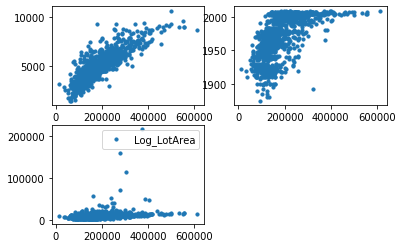

In [17]:
# Plot the different variables
plt.subplot(2,2,1)
plt.scatter(train_hp.SalePrice, train_hp.Gr_tot_SF, s=10, label='gr_tot_SF')
plt.subplot(2,2,2)
plt.scatter(train_hp.SalePrice, train_hp['Year Built'], s=10, label='Year Built')
plt.subplot(2,2,3)
plt.scatter(train_hp.SalePrice, train_hp['Lot Area'], s=10, label='Log_LotArea')
plt.legend()
plt.show()

In [18]:
# Create a linear regression object
lr = LinearRegression()

In [19]:
# Model Lr1a: Linear regression (2 variables: 'Gr_tot_SF','Year Built')

# Fit the model
lr.fit(X_tr_m1a, y_tr_Log)

# Compute predictions
y_pred_m1a = lr.predict(X_te_m1a)

# lr1a MAE (back transformed in USD)
mae_lr1a = MAE(10**y_te_Log, 10**y_pred_m1a)

# Compute RMSE
rmsle_lr1a=RMSE(y_te_Log, y_pred_m1a)

print('lr1 model MAE: {:,.0f} dollars'.format(mae_lr1a))
print('RMSE Lr1a',rmsle_lr1a)

lr1 model MAE: 21,949 dollars
RMSE Lr1a 0.0813565066969173


In [20]:
# Model Lr1b: Linear regression (2 variables: 'Log_LotArea', 'Year Built')

# Fit the model
lr.fit(X_tr_m1b, y_tr_Log)

# Compute predictions
y_pred_m1b = lr.predict(X_te_m1b)

# lr1a MAE (back transformed in USD)
mae_lr1b = MAE(10**y_te_Log, 10**y_pred_m1b)

# Compute RMSE
rmsle_lr1b=RMSE(y_te_Log, y_pred_m1b)

print('lr1 model MAE: {:,.0f} dollars'.format(mae_lr1b))
print('RMSE Lr1b',rmsle_lr1b)

lr1 model MAE: 38,338 dollars
RMSE Lr1b 0.1291970720656274


#### Comparison of models: Lr1a performs better than Lr1b

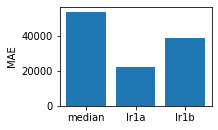

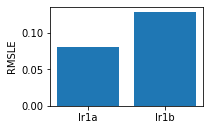

In [21]:
plt.subplot(2,2,1)
mae_values = [mae_baseline, mae_lr1a, mae_lr1b]
titles = ['median', 'lr1a', 'lr1b']
xcor = np.arange(len(mae_values))
plt.bar(xcor, mae_values)
plt.xticks(xcor, titles)
plt.ylabel('MAE')
plt.show()

plt.subplot(2,2,2)
rmsle_values = [rmsle_lr1a, rmsle_lr1b]
titles = ['lr1a', 'lr1b']
xcor1 = np.arange(len(rmsle_values))
plt.bar(xcor1, rmsle_values)
plt.xticks(xcor1, titles)
plt.ylabel('RMSLE')
plt.show()

#### Comparison of Model 1 based on R^2 (implies to rework model with SalePrice and not its Log)

In [22]:
# Model Lr1a_nl: Linear regression (2 variables: 'Gr_tot_SF','Year Built')

# Fit the model
lr.fit(X_tr_m1a, y_tr_noLog)

# Compute predictions
y_pred_m1a_nl = lr.predict(X_te_m1a)

# compute R^2
R2_lr1a_nl = lr.score(X_tr_m1a, y_tr_noLog)

# Model Lr1b_nl: Linear regression (2 variables: 'Log_LotArea', 'Year Built')

# Fit the model
lr.fit(X_tr_m1b, y_tr_noLog)

# Compute predictions
y_pred_m1b_nl = lr.predict(X_te_m1b)

# compute R^2
R2_lr1b_nl = lr.score(X_tr_m1b, y_tr_noLog)

print('R^2 Lr1a_nl', R2_lr1a_nl)
print('R^2 Lr1b_nl', R2_lr1b_nl)


R^2 Lr1a_nl 0.7871426941748263
R^2 Lr1b_nl 0.44808317296951616


### Evaluate feature importance (on train dataset)
* Correlation matrix on numerical features: (correlation >0.7 to SalePrice): **Overall Qual, Tot_liv_SF, Gr_tot_SF, Exter Qual**
* Statistical analysis based on p-values: I have considered features with a **19 features with p-value equal or lower than 0.05, we take the Top 15:**: **Garage Cars**, **Lot Area**, **Overall Cond**, **Overall Qual**, Year Built, **Tot_liv_SF**, **Gr_tot_SF**, **SF_ind, Functional, Exter Qual, Bsmt Qual, Kitchen Qual**, MS Zoning_A (agr), BsmtFin SF 1, Garage Area
* Feature importance analysis based on Random Forest Classifier = Main relevant features:
**Overall Qual**, **Tot_liv_SF**, Year Remod/Add, **Overall Cond**, Garage Area, **TotRms AbvGrd**, Bldg Type_TwnhsE,  (not relevant: Order, LogSalePrice, SalePrice), **SF_ind**, **Gr_tot_SF**, **Garage Cars**, Tot_ext_SF, Garage Type_CarPort, Mo Sold, Lot Area

#### Conclusion
* We will select the following 16 variables for the Model 2, combining features coming out of the 3 feature selection methods and a mix of features from method 2 and 3 covering different house chracteristics:
**Lot Area, Overall Qual, Tot_liv_SF, Gr_tot_SF, Overall Cond, SF_ind, Garage Cars, Functional, Exter Qual, Year Remod/Add, Year Built, Bsmt Qual, Kitchen Qual, Garage Qual, TotRms AbvGrd, TotRms AbvGrd**

* Potential additional features (hot-encoded): neighborhood and MS Zoning

#### Selection of features based on Correlation matrix (target variable is SalePrice)

In [23]:
# Compute the correlation matrix over the entire Dataset (code not activated all the time in order to save computing time)
corr = hp_model.corr()
# Generate a custom diverging colormap
# cmap = sns.diverging_palette(220, 10, as_cmap=True)
# define the style
# corr.style.background_gradient(cmap, axis=1)\
    # .set_properties(**{'max-width': '80px', 'font-size': '10pt'})\
   #  .set_precision(2)\

In [24]:
# Select the features with a correlation score >=0.7
top_features = corr['SalePrice'].sort_values(ascending=False)
# Filter out the target variable (SalePrice) and features with a correlation score > abs(0.7)
top_features = top_features[abs(top_features) >= 0.7]
top_features = top_features[top_features.index != 'SalePrice']
top_features

LogSalePrice    0.948107
Gr_tot_SF       0.842504
Overall Qual    0.807154
Tot_liv_SF      0.806168
Exter Qual      0.715251
Name: SalePrice, dtype: float64

## Calculate p-values for features of the training data set (target feature:  SalePrice - not log)

In [25]:
# Create a dataframe for X values based on Train/Test with relevant features
X_pval=train_hp.drop(['SalePrice','LogSalePrice','PID'], axis=1)
# Reminder for y: y_tr_noLog = train_hp.SalePrice.values

In [26]:
# Perform statiscal analysis to compute p-values per feature
X2 = sm.add_constant(X_pval)
est = sm.OLS(y_tr_noLog, X2)
est2 = est.fit()
print(est2.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.936
Model:                            OLS   Adj. R-squared:                  0.925
Method:                 Least Squares   F-statistic:                     87.47
Date:                Sun, 17 Nov 2019   Prob (F-statistic):               0.00
Time:                        16:19:56   Log-Likelihood:                -13644.
No. Observations:                1207   AIC:                         2.763e+04
Df Residuals:                    1034   BIC:                         2.852e+04
Df Model:                         172                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
Bsmt Full Bath          1968

In [27]:
# 19 variables with a p-value <= 0.05
# Garage Cars
# Lot Area
# Overall Cond
# Overall Qual
# Year Built
# Tot_liv_SF
# Gr_tot_SF
# SF_ind
# Functional
# Exter Qual
# Bsmt Qual
# Kitchen Qual
# MS Zoning_A (agr)
# BsmtFin SF 1
# Garage Area
# Tot_ext_SF
# Bsmt Unf SF
# Garage Qual
# Mas Vnr Type_CBlock


#### Feature importance analysis (Random Forest)

In [28]:
X_rdft=train_hp.drop(['LogSalePrice','PID'], axis=1).values
y_rdft = train_hp['LogSalePrice'].astype(np.int64).values # transform LogSalePrice into int64 to avoid 'continuous' data error

In [29]:
#Scaling the values
X_rdft = preprocessing.scale(X_rdft)

In [30]:
# Create decision tree classifer object
clf = RandomForestClassifier(n_estimators=100,random_state=0, n_jobs=42)

In [31]:
# Train model
model = clf.fit(X_rdft, y_rdft)

In [32]:
# Calculate feature importances
importances = model.feature_importances_

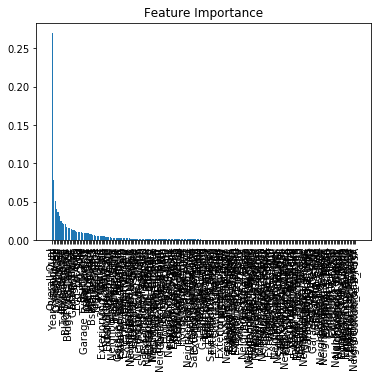

In [33]:
# Sort feature importances in descending order
indices = np.argsort(importances)[::-1]

# Rearrange feature names so they match the sorted feature importances
names = [train_hp.columns[i] for i in indices]

# Create plot
plt.figure()

# Create plot title
plt.title("Feature Importance")

# Add bars
plt.bar(range(X_rdft.shape[1]), importances[indices])

# Add feature names as x-axis labels
plt.xticks(range(X_rdft.shape[1]), names, rotation=90)

# Show plot
plt.show()
plt.rcParams["figure.figsize"] = (30,10)

In [34]:
list(names)

['Overall Qual',
 'Year Remod/Add',
 'Tot_liv_SF',
 'Garage Area',
 'Overall Cond',
 'Gr_tot_SF',
 'Order',
 'LogSalePrice',
 'Fireplace Qu',
 'TotRms AbvGrd',
 'Bldg Type_Twnhs',
 'Bldg Type_TwnhsE',
 'SalePrice',
 'Functional',
 'Bsmt Unf SF',
 'Garage Finish',
 'Lot Area',
 'Log_LotArea',
 'PID',
 'Yr Sold',
 'Mo Sold',
 'Bsmt Cond',
 'Garage Type_CarPort',
 'Tot_ext_SF',
 'BsmtFin SF 1',
 'Garage Qual',
 'Lot Frontage',
 'MS SubClass',
 'BsmtFin Type 1',
 'Garage Cars',
 'Lot Shape',
 'Kitchen Qual',
 'Paved Drive',
 'Fireplaces',
 'Year Built',
 'Exterior 2nd_Wd Sdng',
 'MS Zoning_RH',
 'Foundation_Wood',
 'Roof Style_Mansard',
 'Exterior 1st_BrkFace',
 'Heating QC',
 'Neighborhood_Greens',
 'Heating_OthW',
 'Garage Cond',
 'Bsmt Exposure',
 'Electrical',
 'Garage Type_Basment',
 'Exterior 2nd_Wd Shng',
 'Sale Condition_Alloca',
 'MS Zoning_I (all)',
 'Exterior 2nd_HdBoard',
 'BsmtFin SF 2',
 'Foundation_CBlock',
 'Neighborhood_IDOTRR',
 'Neighborhood_NoRidge',
 'BsmtFin Type 2',


## Model 2 Intermediate model
* Model 2a: Selection of 16 explaining features for based on Feature Importance analysis: **Lot Area, Overall Qual, Tot_liv_SF, Gr_tot_SF, Overall Cond, SF_ind, Garage Cars, Functional, Exter Qual, Year Remod/Add, Year Built, Bsmt Qual, Kitchen Qual, Garage Qual, TotRms AbvGrd, TotRms AbvGrd**
* Model 2b = Model 2a + feature 'neighborhood' and MS Zoning

In [35]:
# Create a dataframe for X values based on Train/Test with relevant features
train_hp_m2a=train_hp[['TotRms AbvGrd','Lot Area', 'Overall Qual', 'Tot_liv_SF', 'Gr_tot_SF', 'Overall Cond', 'SF_ind', 'Garage Cars', 'Functional', 'Exter Qual', 'Year Remod/Add', 'Year Built', 'Bsmt Qual','Kitchen Qual', 'Garage Qual']]
test_hp_m2a=test_hp[['TotRms AbvGrd','Lot Area', 'Overall Qual', 'Tot_liv_SF', 'Gr_tot_SF', 'Overall Cond', 'SF_ind', 'Garage Cars', 'Functional', 'Exter Qual', 'Year Remod/Add', 'Year Built', 'Bsmt Qual','Kitchen Qual', 'Garage Qual']]
train_hp_m2b=train_hp[['TotRms AbvGrd','Lot Area', 'Overall Qual', 'Tot_liv_SF', 'Gr_tot_SF', 'Overall Cond', 'SF_ind', 'Garage Cars', 'Functional', 'Exter Qual', 'Year Remod/Add', 'Year Built', 'Bsmt Qual','Kitchen Qual', 'Garage Qual','Neighborhood_Blmngtn', 'Neighborhood_Blueste', 'Neighborhood_BrDale', 'Neighborhood_BrkSide', 'Neighborhood_ClearCr', 'Neighborhood_CollgCr', 'Neighborhood_Crawfor', 'Neighborhood_Edwards', 'Neighborhood_Gilbert', 'Neighborhood_Greens', 'Neighborhood_GrnHill', 'Neighborhood_IDOTRR', 'Neighborhood_Landmrk', 'Neighborhood_MeadowV', 'Neighborhood_Mitchel', 'Neighborhood_NAmes', 'Neighborhood_NPkVill', 'Neighborhood_NWAmes', 'Neighborhood_NoRidge', 'Neighborhood_NridgHt', 'Neighborhood_OldTown', 'Neighborhood_SWISU', 'Neighborhood_Sawyer', 'Neighborhood_SawyerW', 'Neighborhood_Somerst', 'Neighborhood_StoneBr', 'Neighborhood_Timber', 'Neighborhood_Veenker','MS Zoning_A (agr)', 'MS Zoning_C (all)', 'MS Zoning_FV', 'MS Zoning_I (all)', 'MS Zoning_RH', 'MS Zoning_RL', 'MS Zoning_RM']]
test_hp_m2b=test_hp[['TotRms AbvGrd','Lot Area', 'Overall Qual', 'Tot_liv_SF', 'Gr_tot_SF', 'Overall Cond', 'SF_ind', 'Garage Cars', 'Functional', 'Exter Qual', 'Year Remod/Add', 'Year Built', 'Bsmt Qual','Kitchen Qual', 'Garage Qual','Neighborhood_Blmngtn', 'Neighborhood_Blueste', 'Neighborhood_BrDale', 'Neighborhood_BrkSide', 'Neighborhood_ClearCr', 'Neighborhood_CollgCr', 'Neighborhood_Crawfor', 'Neighborhood_Edwards', 'Neighborhood_Gilbert', 'Neighborhood_Greens', 'Neighborhood_GrnHill', 'Neighborhood_IDOTRR', 'Neighborhood_Landmrk', 'Neighborhood_MeadowV', 'Neighborhood_Mitchel', 'Neighborhood_NAmes', 'Neighborhood_NPkVill', 'Neighborhood_NWAmes', 'Neighborhood_NoRidge', 'Neighborhood_NridgHt', 'Neighborhood_OldTown', 'Neighborhood_SWISU', 'Neighborhood_Sawyer', 'Neighborhood_SawyerW', 'Neighborhood_Somerst', 'Neighborhood_StoneBr', 'Neighborhood_Timber', 'Neighborhood_Veenker','MS Zoning_A (agr)', 'MS Zoning_C (all)', 'MS Zoning_FV', 'MS Zoning_I (all)', 'MS Zoning_RH', 'MS Zoning_RL', 'MS Zoning_RM']]

In [36]:
# Create X variables for intermediate model
X_tr_m2a=train_hp_m2a.values
X_te_m2a=test_hp_m2a.values
X_tr_m2b=train_hp_m2b.values
X_te_m2b=test_hp_m2b.values

In [37]:
# y variables for this model (already created)
# y_tr_Log = train_hp.LogSalePrice.values
# y_te_Log = test_hp.LogSalePrice.values

In [38]:
# Model Lr2a: Linear regression (16 variables)

# Fit the model
lr.fit(X_tr_m2a, y_tr_Log)

# Compute predictions
y_pred_m2a = lr.predict(X_te_m2a)

# lr1a MAE (back transformed in USD)
mae_lr2a = MAE(10**y_te_Log, 10**y_pred_m2a)

# Compute RMSE
rmsle_lr2a=RMSE(y_te_Log, y_pred_m2a)
                
print('lr2a model MAE: {:,.0f} dollars'.format(mae_lr2a))
print('RMSE Lr2a',rmsle_lr2a)


lr2a model MAE: 16,574 dollars
RMSE Lr2a 0.05999336377800252


In [39]:
# Model Lr2b: Linear regression (16 variables + neighborhood + MS Zoning)

# Fit the model
lr.fit(X_tr_m2b, y_tr_Log)

# Compute predictions
y_pred_m2b = lr.predict(X_te_m2b)

# lr2b MAE (back transformed in USD)
mae_lr2b = MAE(10**y_te_Log, 10**y_pred_m2b)

# Compute RMSE
rmsle_lr2b=RMSE(y_te_Log, y_pred_m2b)

print('lr2b model MAE: {:,.0f} dollars'.format(mae_lr2b))
print('RMSE Lr2b',rmsle_lr2b)

lr2b model MAE: 15,477 dollars
RMSE Lr2b 0.05571667515215645


#### Additional model considered as a benchmark by the author of the "Alternative of Boston Housing Data" article

In [40]:
# Model Lr2c: Linear Regression with 3 variables (Total_Liv-SF and Neighborhood transformed with one-hot encoding)
train_hp_m2c=train_hp[['Tot_liv_SF','Neighborhood_Blmngtn', 'Neighborhood_Blueste', 'Neighborhood_BrDale', 'Neighborhood_BrkSide', 'Neighborhood_ClearCr', 'Neighborhood_CollgCr', 'Neighborhood_Crawfor', 'Neighborhood_Edwards', 'Neighborhood_Gilbert', 'Neighborhood_Greens', 'Neighborhood_GrnHill', 'Neighborhood_IDOTRR', 'Neighborhood_Landmrk', 'Neighborhood_MeadowV', 'Neighborhood_Mitchel', 'Neighborhood_NAmes', 'Neighborhood_NPkVill', 'Neighborhood_NWAmes', 'Neighborhood_NoRidge', 'Neighborhood_NridgHt', 'Neighborhood_OldTown', 'Neighborhood_SWISU', 'Neighborhood_Sawyer', 'Neighborhood_SawyerW', 'Neighborhood_Somerst', 'Neighborhood_StoneBr', 'Neighborhood_Timber', 'Neighborhood_Veenker']]
test_hp_m2c=test_hp[['Tot_liv_SF', 'Neighborhood_Blmngtn', 'Neighborhood_Blueste', 'Neighborhood_BrDale', 'Neighborhood_BrkSide', 'Neighborhood_ClearCr', 'Neighborhood_CollgCr', 'Neighborhood_Crawfor', 'Neighborhood_Edwards', 'Neighborhood_Gilbert', 'Neighborhood_Greens', 'Neighborhood_GrnHill', 'Neighborhood_IDOTRR', 'Neighborhood_Landmrk', 'Neighborhood_MeadowV', 'Neighborhood_Mitchel', 'Neighborhood_NAmes', 'Neighborhood_NPkVill', 'Neighborhood_NWAmes', 'Neighborhood_NoRidge', 'Neighborhood_NridgHt', 'Neighborhood_OldTown', 'Neighborhood_SWISU', 'Neighborhood_Sawyer', 'Neighborhood_SawyerW', 'Neighborhood_Somerst', 'Neighborhood_StoneBr', 'Neighborhood_Timber', 'Neighborhood_Veenker']]

In [41]:
# Create X variables for model 2c
X_tr_m2c=train_hp_m2c.values
X_te_m2c=test_hp_m2c.values

In [42]:
# Model Lr2c: Linear regression (3 variables)

# Fit the model
lr.fit(X_tr_m2c, y_tr_Log)

# Compute predictions
y_pred_m2c = lr.predict(X_te_m2c)

# lr1a MAE (back transformed in USD)
mae_lr2c = MAE(10**y_te_Log, 10**y_pred_m2c)

# Compute RMSE
rmsle_lr2c=RMSE(y_te_Log, y_pred_m2c)

print('lr2c model MAE: {:,.0f} dollars'.format(mae_lr2c))
print('RMSE Lr2c',rmsle_lr2c)

lr2c model MAE: 22,950 dollars
RMSE Lr2c 0.08186811318890605


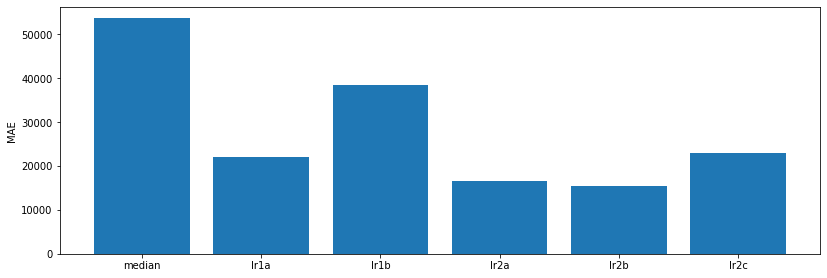

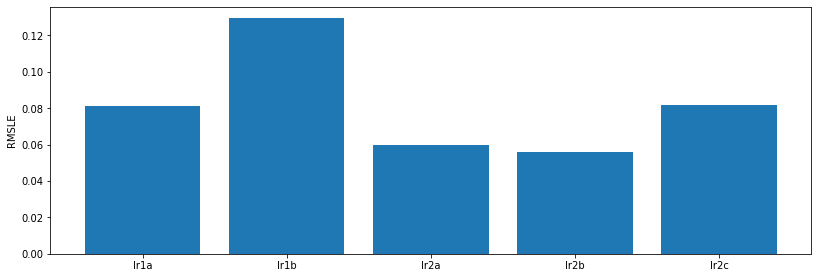

In [43]:
plt.subplot(2,2,1)
mae_values = [mae_baseline, mae_lr1a, mae_lr1b, mae_lr2a, mae_lr2b, mae_lr2c]
titles = ['median', 'lr1a', 'lr1b', 'lr2a', 'lr2b','lr2c']
xcor = np.arange(len(mae_values))
plt.bar(xcor, mae_values)
plt.xticks(xcor, titles)
plt.ylabel('MAE')
plt.show()

plt.subplot(2,2,2)
rmsle_values = [rmsle_lr1a, rmsle_lr1b, rmsle_lr2a, rmsle_lr2b, rmsle_lr2c]
titles = ['lr1a', 'lr1b', 'lr2a','lr2b','lr2c']
xcor1 = np.arange(len(rmsle_values))
plt.bar(xcor1, rmsle_values)
plt.xticks(xcor1, titles)
plt.ylabel('RMSLE')
plt.show()


#### Comparison of Model 2 based on R^2 (implies to rework models with SalePrice and not its Log)

In [44]:
# Model Lr2a_nl: Linear regression (16 variables)

# Fit the model
lr.fit(X_tr_m2a, y_tr_noLog)

# Compute predictions
y_pred_m2a_nl = lr.predict(X_te_m2a)

# compute R^2
R2_lr2a_nl = lr.score(X_tr_m2a, y_tr_noLog)

# Model Lr2b_nl: Linear regression (16 variables + neighborhood + MS Zoning)

# Fit the model
lr.fit(X_tr_m2b, y_tr_noLog)

# Compute predictions
y_pred_m2b_nl = lr.predict(X_te_m2b)

# compute R^2
R2_lr2b_nl = lr.score(X_tr_m2b, y_tr_noLog)

print('R^2 Lr2a_nl', R2_lr2a_nl)
print('R^2 Lr2b_nl', R2_lr2b_nl)


R^2 Lr2a_nl 0.8621966066001785
R^2 Lr2b_nl 0.8883411797143451


In [45]:
# Model Lr2c_nl: Linear regression with 3 variables (Tot_Liv_SF, Overall Qual and Neighborood) - Sale Price (NOT Log)
# Y value based on Sale Price (not Log)
y_tr_noLog = train_hp.SalePrice.values
y_te_noLog = test_hp.SalePrice.values

In [46]:
# Model Lr2c_nl: Linear regression with 3 variables (Tot_Liv_SF, Overall Qual and Neighborood) - Sale Price (NOT Log)

# Fit the model
lr.fit(X_tr_m2c, y_tr_noLog)

# compute R^2
R2_lr2c_nl = lr.score(X_tr_m2c, y_tr_noLog)

# Compute predictions
y_pred_m2c_nl = lr.predict(X_te_m2c)

# lr1a MAE (back transformed in USD)
mae_lr2c_nl = MAE(y_te_noLog, y_pred_m2c_nl)

# Compute RMSE
rmsle_lr2c_nl=RMSE(y_te_noLog, y_pred_m2c_nl)

print('R^2 c2', R2_lr2c_nl)
print('lr2c_nl model MAE: {:,.0f} dollars'.format(mae_lr2c_nl))
print('RMSE Lr2c_nl',rmsle_lr2c_nl)

R^2 c2 0.8158108162979293
lr2c_nl model MAE: 24,997 dollars
RMSE Lr2c_nl 36604.24473477537


#### Summary table of R^2 scores for all models (based on SalePrice; not log transformed)

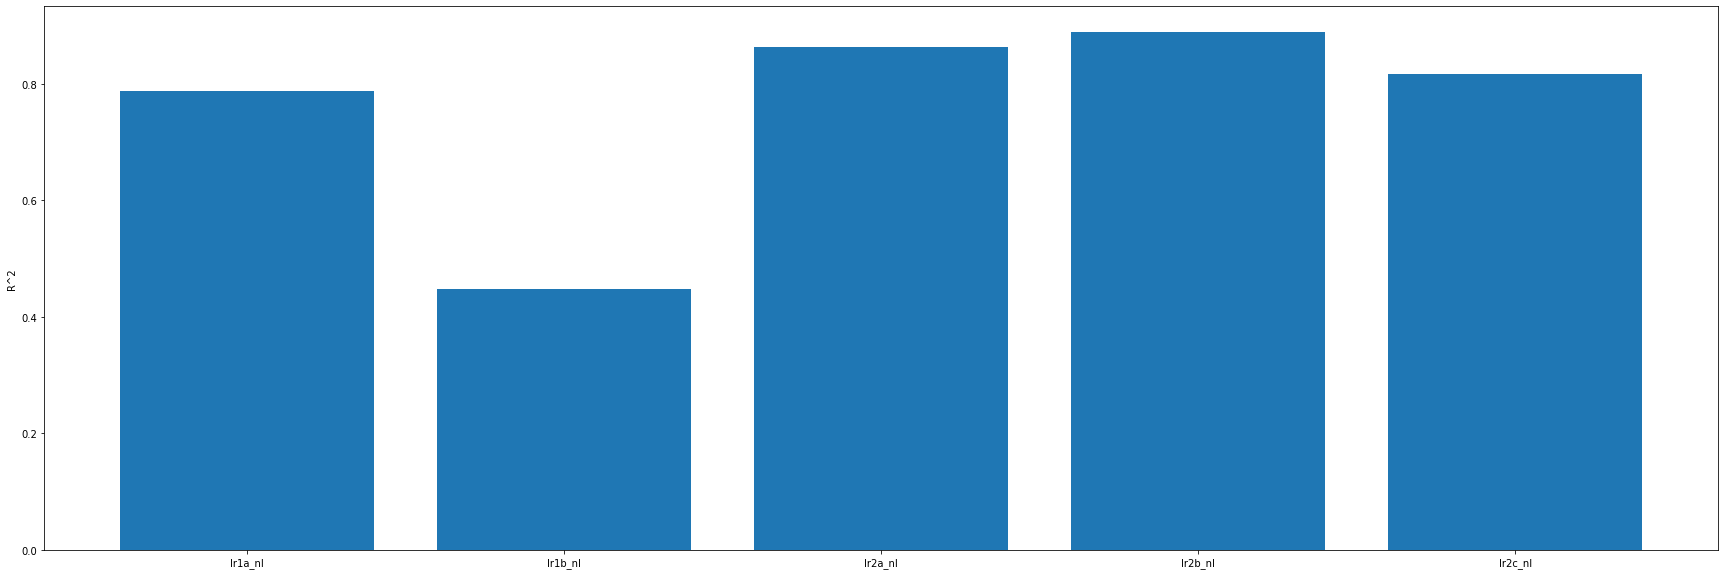

In [47]:
r2_values = [R2_lr1a_nl, R2_lr1b_nl, R2_lr2a_nl, R2_lr2b_nl, R2_lr2c_nl]
titles = ['lr1a_nl', 'lr1b_nl','lr2a_nl','lr2b_nl','lr2c_nl']
xcor2 = np.arange(len(r2_values))
plt.bar(xcor2, r2_values)
plt.xticks(xcor2, titles)
plt.ylabel('R^2')
plt.show()


#### Additional check of the quality of the model through the residual plot (Model Lr2b: 16 variables + neighborood & MS Zoning hot-encoded)
* There is not a specific pattern in the residual distribution. Residuals seem to be randomly distributed around the regression line. We could conclude that the model is a appropriate.

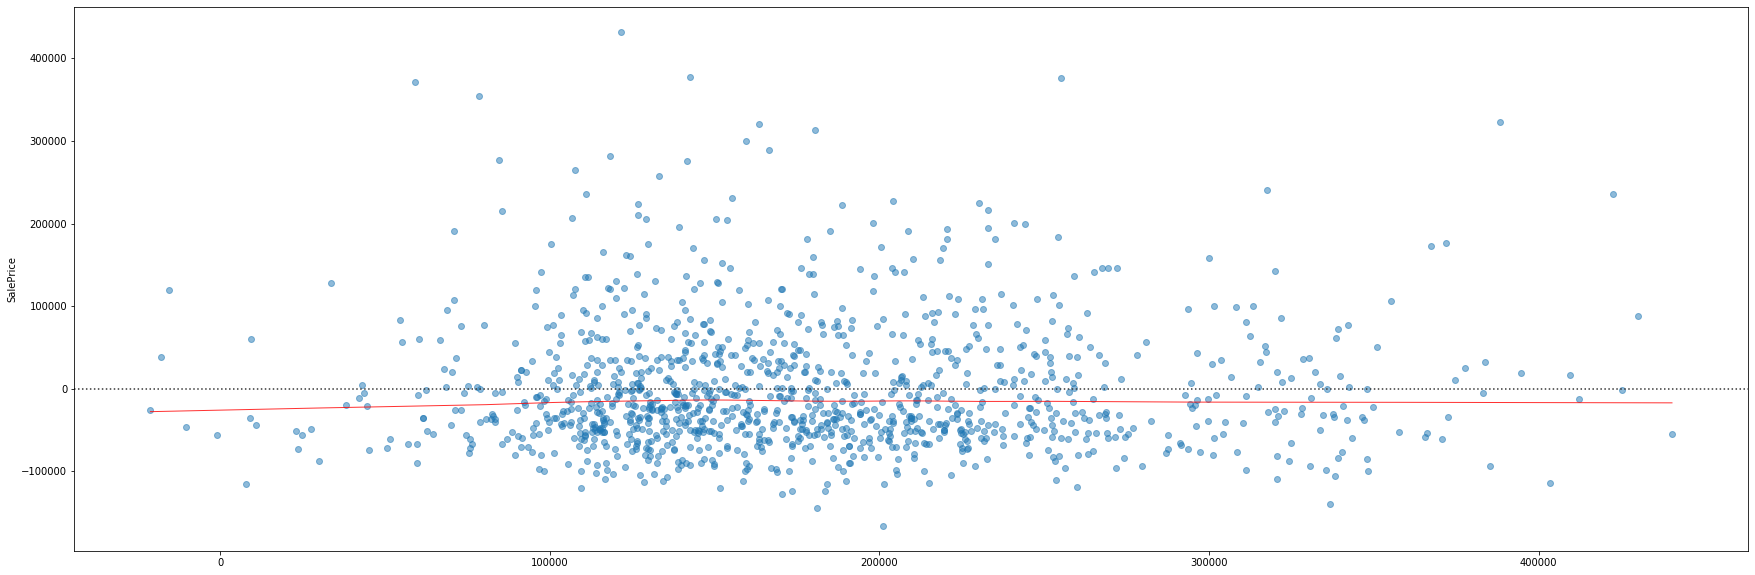

In [48]:
sns.residplot(y_pred_m2b_nl, train_hp['SalePrice'], lowess=True, scatter_kws={'alpha': 0.5}, 
                          line_kws={'color': 'red', 'lw': 1, 'alpha': 0.8})

## Model 3 Complex model
* Linear Regression with all features: lr3a model MAE: 14,200 dollars, RMSE Lr3a 0.055383118588
* Slightly better than Model Lr2b: lr2b model MAE: 15,695 dollars, RMSE Lr2b 0.0569027082257

In [49]:
# Model Lr3a: Linera Regression with all features
train_hp_m3a=train_hp.drop(['SalePrice','LogSalePrice'], axis=1)
test_hp_m3a=test_hp.drop(['SalePrice','LogSalePrice'], axis=1)

#### Save train and target data sets for the prediction in Part III

In [50]:
# Save the dataset train_hp_m3a to a csv file
# train_hp_m3a.to_csv('train_features_m3a_new.csv')

In [51]:
# Create X variables for intermediate model
X_tr_m3a=train_hp_m3a.values
X_te_m3a=test_hp_m3a.values

In [52]:
# y variables for this model (already created)
# y_tr_Log = train_hp.LogSalePrice.values
# y_te_Log = test_hp.LogSalePrice.values

In [53]:
# Model Lr3a: Linear regression with all variables

# Fit the model
lr.fit(X_tr_m3a, y_tr_Log)

# Compute predictions
y_pred_m3a = lr.predict(X_te_m3a)

# lr1a MAE (back transformed in USD)
mae_lr3a = MAE(10**y_te_Log, 10**y_pred_m3a)

# Compute RMSE
rmsle_lr3a=RMSE(y_te_Log, y_pred_m3a)

print('lr3a model MAE: {:,.0f} dollars'.format(mae_lr3a))
print('RMSE Lr3a',rmsle_lr3a)

lr3a model MAE: 14,074 dollars
RMSE Lr3a 0.05487368985526134


## Adding Ridge Regression to Model 2b and 3

#### Ridge Regression based on Model 2
* Scores of Linear regression and Ridge Regression are very similar, even if we apply a Grid Search optimization on the Ridge regression model
* Linear Regression: **RMSE Lr2b = 0.0569027082257**
* Ridge Regression (Alpha optimized): **RMSE Ridge RMSE train: 0.055844 test: 0.056785**

In [54]:
# Model Lr2b: Linear regression (16 variables + neighborhood + MS Zoning) + Ridge Regression

# Fit the model
lr.fit(X_tr_m2b, y_tr_Log)

# Compute predictions
y_pred_m2b = lr.predict(X_te_m2b)

# lr2b MAE (back transformed in USD)
mae_lr2b = MAE(10**y_te_Log, 10**y_pred_m2b)

# Compute RMSE
rmsle_lr2b=RMSE(y_te_Log, y_pred_m2b)


# Fit Ridge Regression
ridge2 = Ridge()
ridge2.fit(X_tr_m2b, y_tr_Log)

# compute prediction
y_pred_ridge2 = ridge2.predict(X_te_m2b)

# Ridge2 MAE
mae_ridge2 = MAE(10**y_te_Log, 10**y_pred_ridge2)

# compute RMSE
rmsle_ridge2 = RMSE (y_te_Log, y_pred_ridge2)


print('lr2b model MAE: {:,.0f} dollars'.format(mae_lr2b))
print('Ridge model MAE: {:,.0f} dollars'.format(mae_ridge2))
print('RMSE Lr2b',rmsle_lr2b)
print('RMSE Ridge2',rmsle_ridge2)


lr2b model MAE: 15,477 dollars
Ridge model MAE: 15,436 dollars
RMSE Lr2b 0.05571667515215645
RMSE Ridge2 0.055610030539185


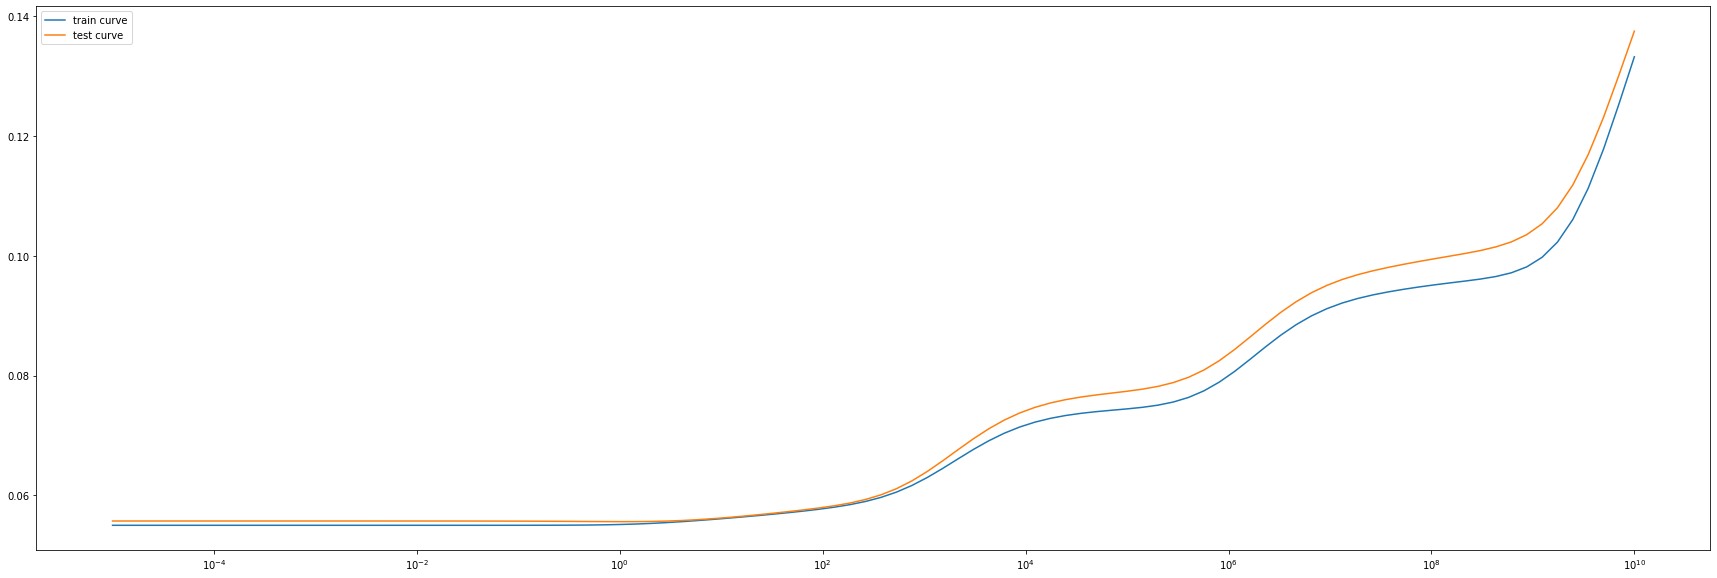

In [55]:
# Define a set of alpha values
alphas = np.logspace(-5, 10, num=100)

# Save train/test scores
train_scores = []
test_scores = []

# Grid search
for alpha in alphas:
    # Ridge regression
    ridge = Ridge(alpha)
    ridge.fit(X_tr_m2b, y_tr_Log)
    
    # Train score
    y_pred_rtr = ridge.predict(X_tr_m2b)
    train_scores.append(RMSE(y_tr_Log, y_pred_rtr))
    
    # Test score
    y_pred_rte = ridge.predict(X_te_m2b)
    test_scores.append(RMSE(y_te_Log, y_pred_rte))
    
# Plot validation curves
plt.semilogx(alphas, train_scores, label='train curve')
plt.semilogx(alphas, test_scores, label='test curve')
plt.legend()
plt.show()

In [56]:
# Find best alpha
idx = np.argmin(test_scores)
best_alpha = alphas[idx]
print('Best alpha {:}'.format(best_alpha))

# Print train/test scores
print('Ridge regression 2 - RMSE train: {:,f} test: {:,f}'.format(
    train_scores[idx],
    test_scores[idx]
))

Best alpha 1.0
Ridge regression 2 - RMSE train: 0.055132 test: 0.055610


In [57]:
# Fit Ridge Regression with Best Alpha
ridge2 = Ridge(1)
ridge2.fit(X_tr_m2b, y_tr_Log)

# compute prediction
y_pred_ridge2 = ridge2.predict(X_te_m2b)

# Ridge2 MAE
mae_ridge2b = MAE(10**y_te_Log, 10**y_pred_ridge2)

# compute RMSE
rmsle_ridge2b = RMSE (y_te_Log, y_pred_ridge2)


print('Ridge Best Alpha model MAE: {:,.0f} dollars'.format(mae_ridge2b))
print('RMSE Best Alpha Ridge2',rmsle_ridge2b)


Ridge Best Alpha model MAE: 15,436 dollars
RMSE Best Alpha Ridge2 0.055610030539185


#### Ridge Regression based on Model 3
* Ridge Regression with Alpha Optimized is better than the Linear Regression of the complex model 3 (whilst Linear Regression and Ridge Regeression not optimized perform equally)
* Linear Regression with all features: lr3a model MAE: 14,200 dollars, RMSE Lr3a 0.055383118588
* Ridge Regression (Alpha optimized): Ridge Best Alpha model MAE: 13,234 dollars, MSE Best Alpha Ridge3 0.0515150414601

In [58]:
# Model Lr3a: Linear regression (All variables) + Ridge Regression

# Fit the model
lr.fit(X_tr_m3a, y_tr_Log)

# Compute predictions
y_pred_m3a = lr.predict(X_te_m3a)

# lr MAE (back transformed in USD)
mae_lr3a= MAE(10**y_te_Log, 10**y_pred_m3a)

# Compute RMSE
rmsle_lr3a=RMSE(y_te_Log, y_pred_m3a)


# Fit Ridge Regression
ridge3 = Ridge()
ridge3.fit(X_tr_m3a, y_tr_Log)

# compute prediction
y_pred_ridge3 = ridge3.predict(X_te_m3a)

# Ridge2 MAE
mae_ridge3 = MAE(10**y_te_Log, 10**y_pred_ridge3)

# compute RMSE
rmsle_ridge3 = RMSE (y_te_Log, y_pred_ridge3)


print('lr3a model MAE: {:,.0f} dollars'.format(mae_lr3a))
print('Ridge model MAE: {:,.0f} dollars'.format(mae_ridge3))
print('RMSE Lr3a',rmsle_lr3a)
print('RMSE Ridge3',rmsle_ridge3)

lr3a model MAE: 14,074 dollars
Ridge model MAE: 13,587 dollars
RMSE Lr3a 0.05487368985526134
RMSE Ridge3 0.05219262809465023


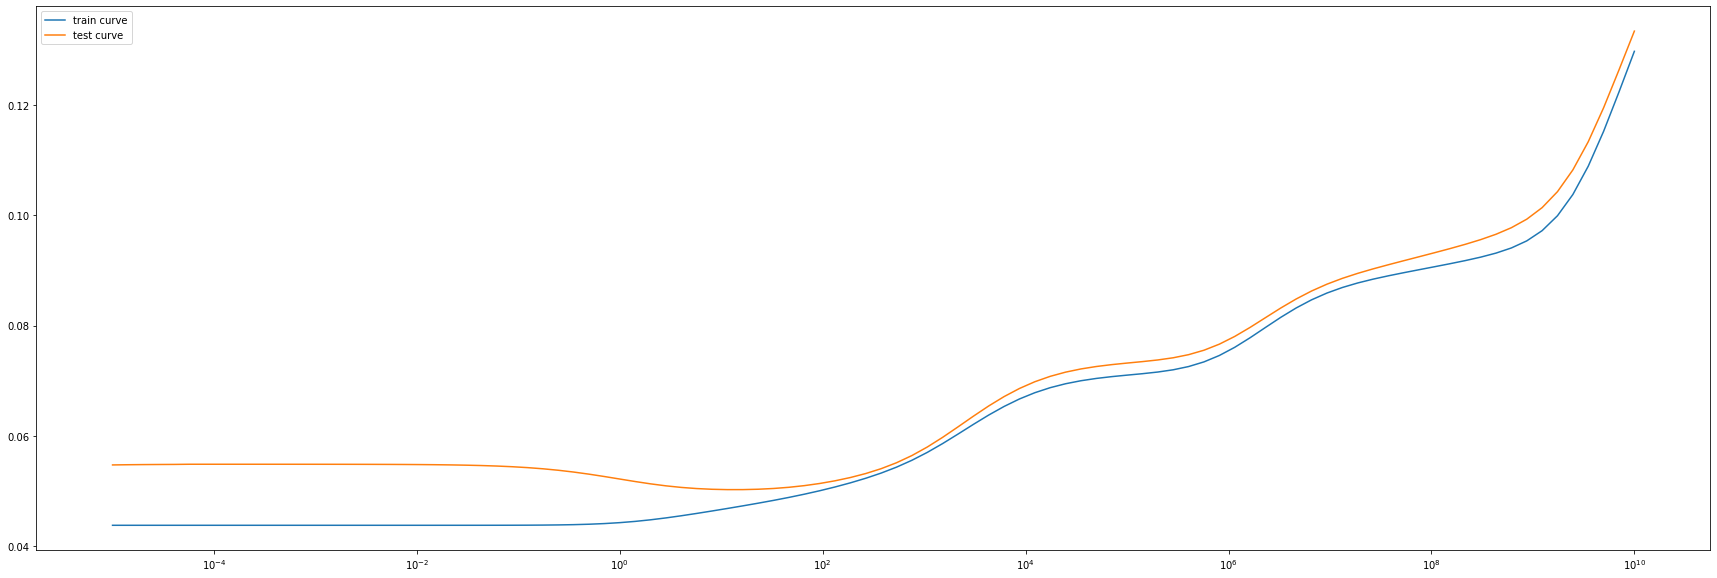

In [59]:
# Define a set of alpha values
alphas = np.logspace(-5, 10, num=100)

# Save train/test scores
train_scores = []
test_scores = []

# Grid search
for alpha in alphas:
    # Ridge regression
    ridge = Ridge(alpha)
    ridge.fit(X_tr_m3a, y_tr_Log)
    
    # Train score
    y_pred_rtr1 = ridge.predict(X_tr_m3a)
    train_scores.append(RMSE(y_tr_Log, y_pred_rtr1))
    
    # Test score
    y_pred_rte1 = ridge.predict(X_te_m3a)
    test_scores.append(RMSE(y_te_Log, y_pred_rte1))
    
# Plot validation curves
plt.semilogx(alphas, train_scores, label='train curve')
plt.semilogx(alphas, test_scores, label='test curve')
plt.legend()
plt.show()

In [60]:
# Find best alpha
idx = np.argmin(test_scores)
best_alpha = alphas[idx]
print('Best alpha {:}'.format(best_alpha))

# Print train/test scores
print('Ridge regression 3 - RMSE train: {:,f} test: {:,f}'.format(
    train_scores[idx],
    test_scores[idx]
))

Best alpha 11.497569953977356
Ridge regression 3 - RMSE train: 0.046863 test: 0.050276


In [61]:
# Fit Ridge Regression Best Alpha
ridge3 = Ridge(11.497569953977356)
ridge3.fit(X_tr_m3a, y_tr_Log)

# compute prediction
y_pred_ridge3 = ridge3.predict(X_te_m3a)

# Ridge2 MAE
mae_ridge3b = MAE(10**y_te_Log, 10**y_pred_ridge3)

# compute RMSE
rmsle_ridge3b = RMSE (y_te_Log, y_pred_ridge3)


print('Ridge Best Alpha model MAE: {:,.0f} dollars'.format(mae_ridge3b))
print('RMSE Best Alpha Ridge3',rmsle_ridge3b)

Ridge Best Alpha model MAE: 13,189 dollars
RMSE Best Alpha Ridge3 0.05027579486261905


#### Build Model 3 with Ridge regression with SalePrice variable (not its log) in order to check the R^2 of the model

In [62]:
# define the set of data to be computed
# Y value based on Sale Price (not Log)
y_tr_noLog = train_hp.SalePrice.values
y_te_noLog = test_hp.SalePrice.values

In [63]:
# Fit Ridge Regression
ridge3_nolog = Ridge()
ridge3_nolog.fit(X_tr_m3a, y_tr_noLog)

# compute prediction
y_pred_ridge3_nolog = ridge3_nolog.predict(X_te_m3a)

# Ridge2 MAE
mae_ridge3_nolog = MAE(y_te_noLog, y_pred_ridge3_nolog)

# compute RMSE
rmsle_ridge3_nolog = RMSE (y_te_noLog, y_pred_ridge3_nolog)


print('Ridge model 3 no log MAE: {:,.0f} dollars'.format(mae_ridge3_nolog))
print('RMSE Ridge3 no log',rmsle_ridge3_nolog)

Ridge model 3 no log MAE: 16,173 dollars
RMSE Ridge3 no log 23634.813871514212


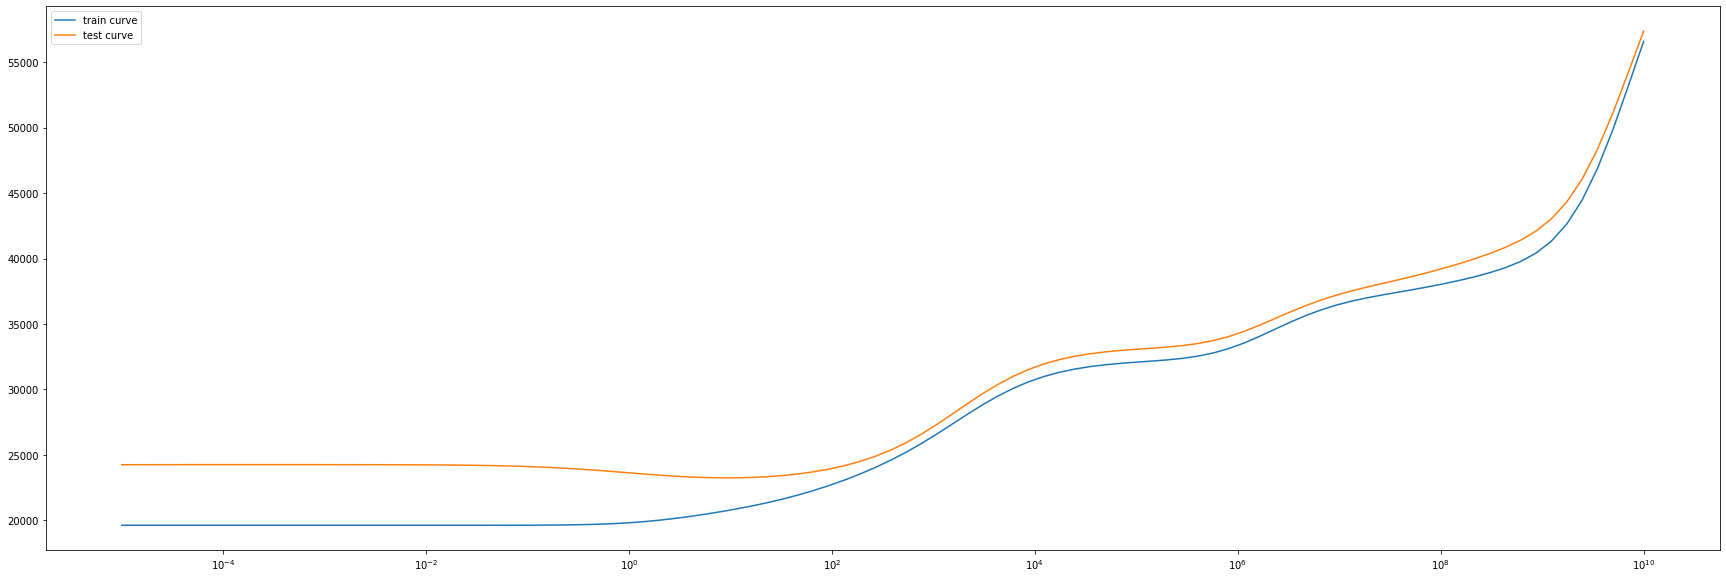

In [64]:
# Define a set of alpha values
alphas = np.logspace(-5, 10, num=100)

# Save train/test scores
train_scores = []
test_scores = []

# Grid search
for alpha in alphas:
    # Ridge regression
    ridge_nolog = Ridge(alpha)
    ridge_nolog.fit(X_tr_m3a, y_tr_noLog)
    
    # Train score
    y_pred_rtr3 = ridge_nolog.predict(X_tr_m3a)
    train_scores.append(RMSE(y_tr_noLog, y_pred_rtr3))
    
    # Test score
    y_pred_rte3 = ridge_nolog.predict(X_te_m3a)
    test_scores.append(RMSE(y_te_noLog, y_pred_rte3))
    
# Plot validation curves
plt.semilogx(alphas, train_scores, label='train curve')
plt.semilogx(alphas, test_scores, label='test curve')
plt.legend()
plt.show()

In [65]:
# Find best alpha
idx = np.argmin(test_scores)
best_alpha = alphas[idx]
print('Best alpha {:}'.format(best_alpha))

# Print train/test scores
print('Ridge regression 3 No Log- RMSE train: {:,f} test: {:,f}'.format(
    train_scores[idx],
    test_scores[idx]
))

Best alpha 8.111308307896872
Ridge regression 3 No Log- RMSE train: 20,672.221110 test: 23,251.624042


In [66]:
# Fit Ridge Regression Best Alpha
ridge3b_nolog = Ridge(8.111308307896872)
ridge3b_nolog.fit(X_tr_m3a, y_tr_noLog)

# compute prediction
y_pred_ridge3b = ridge3b_nolog.predict(X_te_m3a)

# Ridge2 MAE
mae_ridge3b_nolog = MAE(y_te_noLog, y_pred_ridge3b)

# compute RMSE
rmsle_ridge3b_nolog = RMSE (y_te_noLog, y_pred_ridge3b)


print('Ridge Best Alpha model 3 no log MAE: {:,.0f} dollars'.format(mae_ridge3b))
print('RMSE Best Alpha Ridge3 no log',rmsle_ridge3b)

Ridge Best Alpha model 3 no log MAE: 13,189 dollars
RMSE Best Alpha Ridge3 no log 0.05027579486261905


In [67]:
# compute R^2
R2_Ridge3b_nl = ridge3b_nolog.score(X_tr_m3a, y_tr_noLog)
R2_Ridge3b_nl


0.9286914567349084

#### Visualization of results and final decision about the best model
* **Final decision: Model 3 All variables - Ridge Regression with optimized Alpha**

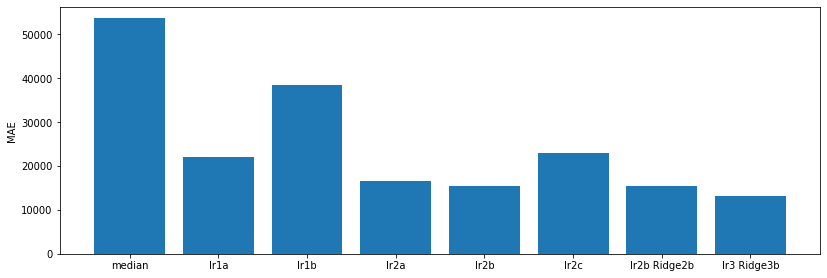

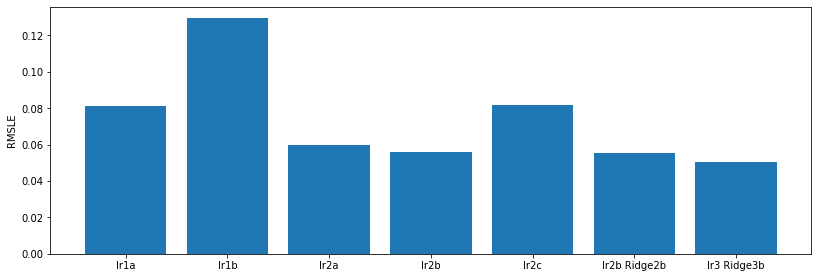

In [68]:
plt.subplot(2,2,1)
mae_values = [mae_baseline, mae_lr1a, mae_lr1b, mae_lr2a, mae_lr2b, mae_lr2c, mae_ridge2b, mae_ridge3b]
titles = ['median', 'lr1a', 'lr1b', 'lr2a', 'lr2b','lr2c','lr2b Ridge2b', 'lr3 Ridge3b']
xcor = np.arange(len(mae_values))
plt.bar(xcor, mae_values)
plt.xticks(xcor, titles)
plt.ylabel('MAE')
plt.show()

plt.subplot(2,2,2)
rmsle_values = [rmsle_lr1a, rmsle_lr1b, rmsle_lr2a, rmsle_lr2b, rmsle_lr2c, rmsle_ridge2b, rmsle_ridge3b]
titles = ['lr1a', 'lr1b', 'lr2a','lr2b','lr2c','lr2b Ridge2b', 'lr3 Ridge3b']
xcor1 = np.arange(len(rmsle_values))
plt.bar(xcor1, rmsle_values)
plt.xticks(xcor1, titles)
plt.ylabel('RMSLE')
plt.show()


##### Residuals plots of Model Lr2b_nl (no log, 15 variables + neighborhood) and Model 3b (no log, all variables, optimized Ridge regression)
* Residuals for both models appear to be ramdomly distributed (no clear pattern detected)
* Both models are good

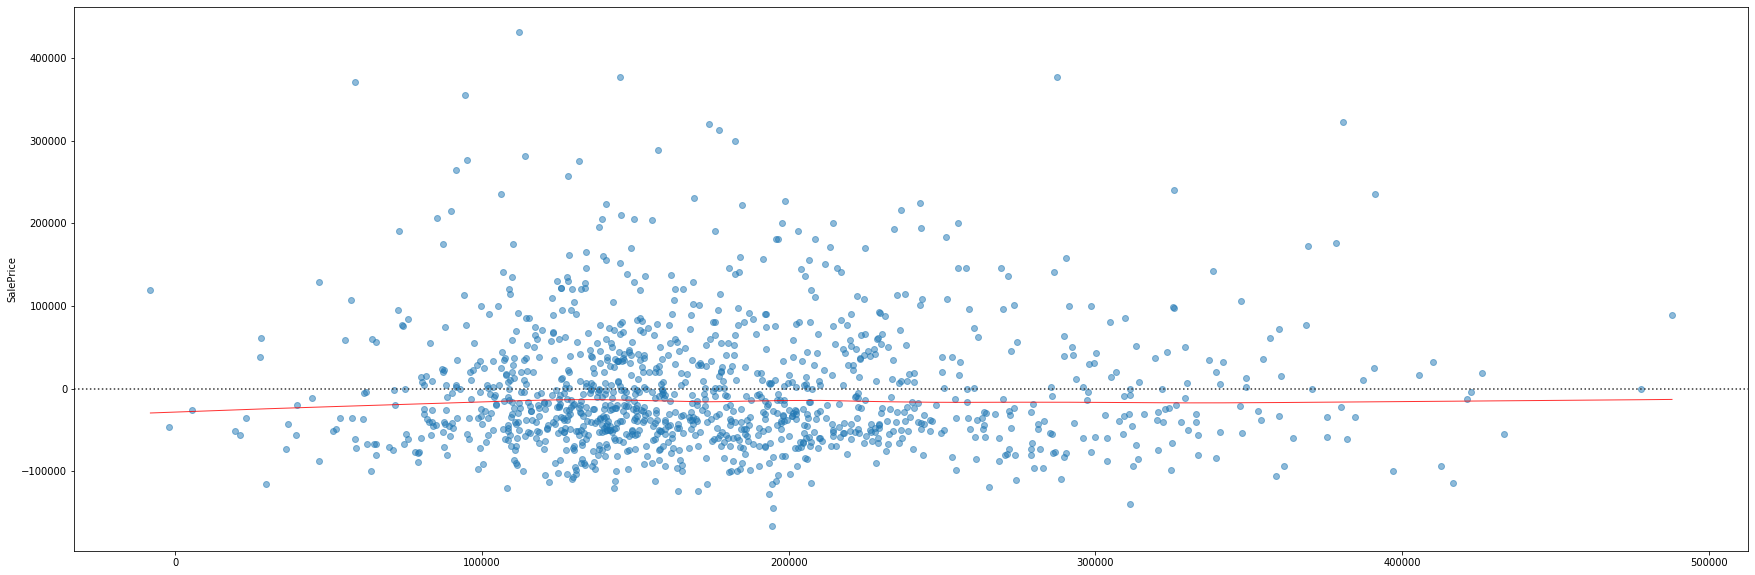

In [69]:
# Residuals plot for Model 3b (Ridge regression)
sns.residplot(y_pred_ridge3b, train_hp['SalePrice'], lowess=True, scatter_kws={'alpha': 0.5}, 
                          line_kws={'color': 'red', 'lw': 1, 'alpha': 0.8})

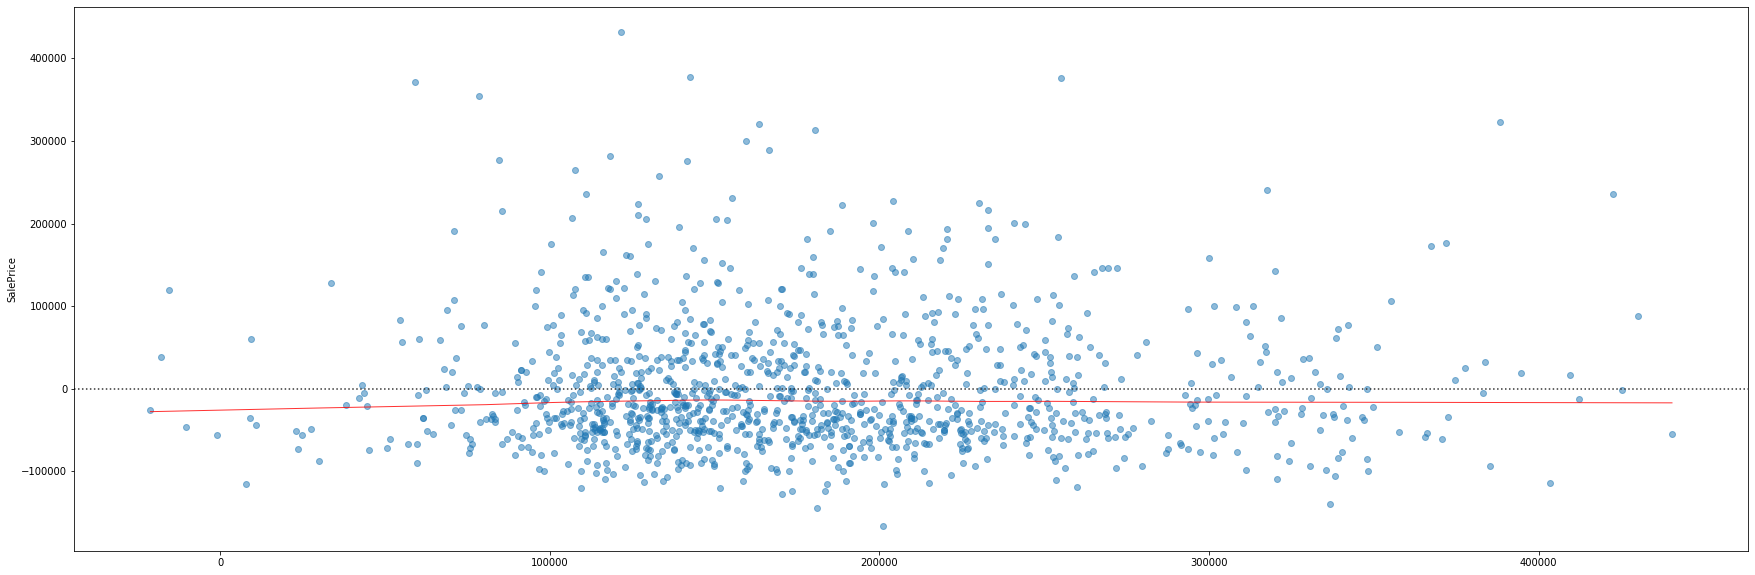

In [70]:
# Residuals plot for Model 2b (linear regression)
sns.residplot(y_pred_m2b_nl, train_hp['SalePrice'], lowess=True, scatter_kws={'alpha': 0.5}, 
                          line_kws={'color': 'red', 'lw': 1, 'alpha': 0.8})

#### Comparison of R^2 of Model 2b (15 variable + neighborhood) and Model 3 Ridge Regression optimized (all variables)

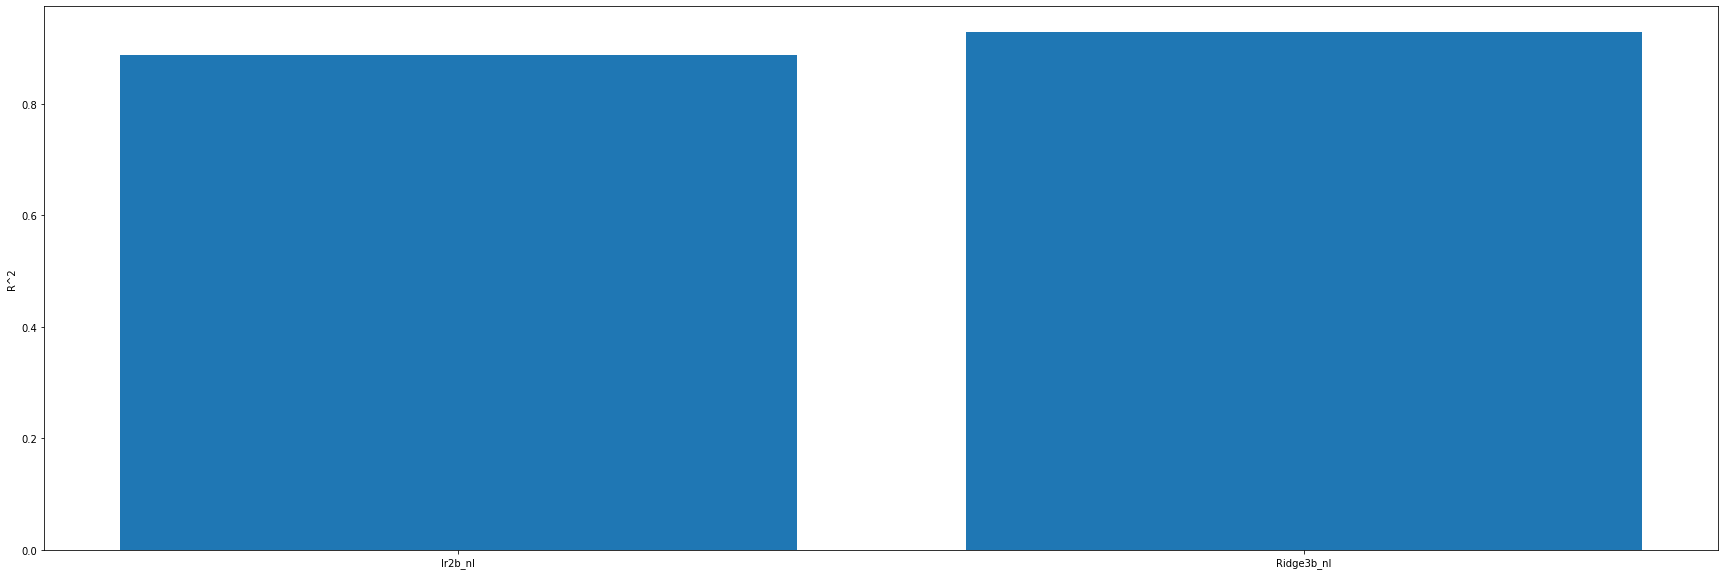

In [71]:
r2_values = [R2_lr2b_nl, R2_Ridge3b_nl]
titles = ['lr2b_nl','Ridge3b_nl']
xcor2 = np.arange(len(r2_values))
plt.bar(xcor2, r2_values)
plt.xticks(xcor2, titles)
plt.ylabel('R^2')
plt.show()
